In [224]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import f_regression

In [225]:
team_stats = pd.read_csv("../data/team_stats_1.csv")
team_stats_df = pd.DataFrame(team_stats.ix[:,1:9])
team_stats_df.head()

,Cfperc,Ffperc,PDO,Foperc,oiSHperc,oZSperc,Playoff,ConfFinal
0,0.527,0.524,0.989,0.494,0.093,0.537,0,0
1,0.591,0.592,0.996,0.533,0.089,0.605,1,1
2,0.512,0.512,0.983,0.498,0.090,0.528,0,0
3,0.539,0.550,0.991,0.523,0.079,0.589,1,0
4,0.529,0.536,0.994,0.512,0.094,0.534,1,0


In [226]:
team_stats_df.describe()

,Cfperc,Ffperc,PDO,Foperc,oiSHperc,oZSperc,Playoff,ConfFinal
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,0.499456,0.500081,1.000056,0.499956,0.090604,0.510752,0.474074,0.118519
std,0.027959,0.027741,0.011996,0.019997,0.008479,0.027373,0.500255,0.323821
min,0.380000,0.393000,0.963000,0.442000,0.069000,0.424000,0.000000,0.000000
25%,0.480250,0.482000,0.993000,0.486000,0.085000,0.494000,0.000000,0.000000
50%,0.501500,0.502000,1.001000,0.501000,0.091000,0.512000,0.000000,0.000000
75%,0.520000,0.520000,1.007000,0.513000,0.096000,0.527750,1.000000,0.000000
max,0.591000,0.592000,1.033000,0.564000,0.116000,0.605000,1.000000,1.000000


In [227]:
features=list(team_stats_df.columns)[0:-2]

In [228]:
import itertools
feature_list = []
for i in range(1,len(features)+1):
    for j in itertools.combinations(features,i):
        feature_list.append(list(j))

### Starting off with logistic regression.
#### We're going to do models for both the playoffs and the conference finals as our dependent variable.

In [229]:
def make_playoff(features):
    model = LogisticRegression()
    X = team_stats_df[features]
    Y = team_stats_df["Playoff"]
    logmod = model.fit(X,Y)
    score = get_score(logmod,X,Y)
    result = [score, features]
    return result

In [230]:
def get_params(features):
    model = LogisticRegression()
    X = team_stats_df[features]
    Y = team_stats_df["Playoff"]
    logmod = model.fit(X,Y)
    coefs = logmod.coef_
    inter = logmod.intercept_
    pval = f_regression(X,Y)[1]
    return coefs, inter, pval

In [231]:
def get_score(model,x,y):
    shuffle=ShuffleSplit(len(x),n_iter=5,test_size=0.2)
    scores = cross_val_score(model,x,y,scoring="roc_auc",cv=shuffle)
    result = scores.mean()
    return result

In [232]:
rank=[]
for i in feature_list:
    rank.append(make_playoff(i))

In [233]:
rank.sort()
rank = rank[-5:]
print("Here are the models and our ROC-AUC score for the five best models. We'll need \n "\
      "to check the collinearity (remember what we did in the data mgmt file?)\n")
for i in rank:
    print i

Here are the models and our ROC-AUC score for the five best models. We'll need 
 to check the collinearity (remember what we did in the data mgmt file?)

[0.7889738506136974, ['Cfperc', 'Ffperc', 'oiSHperc']]
[0.79001715948778517, ['PDO']]
[0.79629101691514026, ['Ffperc', 'Foperc', 'oiSHperc']]
[0.80523635135837102, ['Cfperc', 'Ffperc', 'Foperc', 'oiSHperc']]
[0.81575376345427431, ['Ffperc', 'PDO']]


In [234]:
team_stats_corr = team_stats_df.corr(method="pearson")
(team_stats_corr > .75) | (team_stats_corr<(-.75))

,Cfperc,Ffperc,PDO,Foperc,oiSHperc,oZSperc,Playoff,ConfFinal
Cfperc,True,True,False,False,False,True,False,False
Ffperc,True,True,False,False,False,True,False,False
PDO,False,False,True,False,False,False,False,False
Foperc,False,False,False,True,False,False,False,False
oiSHperc,False,False,False,False,True,False,False,False
oZSperc,True,True,False,False,False,True,False,False
Playoff,False,False,False,False,False,False,True,False
ConfFinal,False,False,False,False,False,False,False,True


#### From 5th to 1st, the following models posess no collinearity with a |0.75| Pearson coefficient cutoff.
5, 4, 2, 1. 
#### So we ignore the 3rd dataset.

In [235]:
mods = [0,1,3,4]
param_list = []
coefs = []
for i in mods:
    param_list.append(rank[i][1])
for i in param_list:
    coefs.append(get_params(i))
results = pd.DataFrame(coefs, columns=["Coefficients","Intercept","Pvals"])
results

,Coefficients,Intercept,Pvals
0,"[[0.920914756579, 1.03360658391, 0.196577945025]]",[-1.08244093868],"[1.14255750987e-12, 9.00596462977e-15, 2.26187..."
1,[[0.324092047216]],[-0.421644606544],[8.16290607946e-16]
2,"[[0.911004001848, 1.0237131784, 0.060105315639...",[-1.10214019838],"[1.14255750987e-12, 9.00596462977e-15, 6.63360..."
3,"[[1.24356069599, 0.0179544324121]]",[-0.73277701482],"[9.00596462977e-15, 8.16290607946e-16]"


In [236]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn import dummy

#### Our best score came from the feature set ('Cfperc', 'PDO', 'Foperc', 'oiSHperc') so let's plot that ROC Curve

In [245]:
baseline = dummy.DummyClassifier()
baseline.fit(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']],team_stats_df["Playoff"])
team_stats_df["baseline"]=baseline.predict_proba(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']]).T[1]
predictions = LogisticRegression()
predictions.fit(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']], team_stats_df['Playoff'])
team_stats_df['predictions'] = predictions.predict_proba(team_stats_df[['Cfperc', 'PDO', 'Foperc', 'oiSHperc']]).T[1]

## <font color="red">Need help with ROC curve</font>

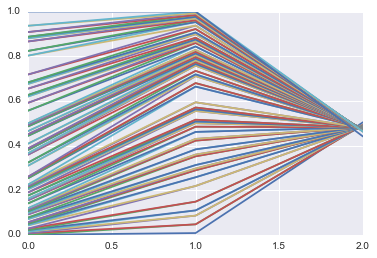

In [250]:
val_1 = roc_curve(team_stats_df["Playoff"],team_stats_df['baseline'])
val_2 = roc_curve(team_stats_df["Playoff"],team_stats_df['predictions'])
plt.plot(val_2)
#set(title='Area Under the Curve for making playoffs', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

#### But since SciKit is pretty aweful at making a good looking summary, we're going to make the models again with stats models to print out the data.

In [239]:
import statsmodels.api as sm
#Bring in intercept
team_stats_df["intercept"]=1
team_stats_df = team_stats_df[['intercept','Cfperc','Ffperc','PDO','Foperc','oiSHperc','oZSperc','Playoff','ConfFinal']]

In [240]:
team_stats_df.head()

,intercept,Cfperc,Ffperc,PDO,Foperc,oiSHperc,oZSperc,Playoff,ConfFinal
0,1,0.527,0.524,0.989,0.494,0.093,0.537,0,0
1,1,0.591,0.592,0.996,0.533,0.089,0.605,1,1
2,1,0.512,0.512,0.983,0.498,0.090,0.528,0,0
3,1,0.539,0.550,0.991,0.523,0.079,0.589,1,0
4,1,0.529,0.536,0.994,0.512,0.094,0.534,1,0


In [241]:
for i in param_list:
    i.insert(0,"intercept")

In [242]:
def stats_logit(features):
    logit_mod = sm.Logit(team_stats_df["Playoff"],team_stats_df[features])
    logit_res = logit_mod.fit()
    print(logit_res.summary())

In [243]:
for i in param_list:
    stats_logit(i)

Optimization terminated successfully.
         Current function value: 0.496673
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Playoff   No. Observations:                  270
Model:                          Logit   Df Residuals:                      266
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Mar 2016   Pseudo R-squ.:                  0.2821
Time:                        23:21:50   Log-Likelihood:                -134.10
converged:                       True   LL-Null:                       -186.79
                                        LLR p-value:                 1.088e-22
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept    -41.0879      5.431     -7.565      0.000       -51.733   -30.443
Cfperc        -1.4109     23.

#### Our restults show that we don't have any models that give us a complete list of statistically significant coefficients, so it looks like we'll need to try another model set, or maybe bring in new data.